##Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from niapy.task import Task
from niapy.problems import Problem
from niapy.algorithms.basic import GreyWolfOptimizer

##df

In [2]:
X_train_path = "D:\Daffa Data\Telkom Folder\semester 7\Tugas Akhir\data\FIX BANGET\X_train.csv"
X_test_path = "D:\Daffa Data\Telkom Folder\semester 7\Tugas Akhir\data\FIX BANGET\X_test.csv"
y_train_path = "D:\Daffa Data\Telkom Folder\semester 7\Tugas Akhir\data\FIX BANGET\y_train.csv"
y_test_path = "D:\Daffa Data\Telkom Folder\semester 7\Tugas Akhir\data\FIX BANGET\y_test.csv"

X_train_df = pd.read_csv(X_train_path)
X_test_df = pd.read_csv(X_test_path)
y_train_df = pd.read_csv(y_train_path)
y_test_df = pd.read_csv(y_test_path)

X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values.ravel()
y_test = y_test_df.values.ravel()

X_train_df  = X_train_df.drop(columns=['FDA_APPROVED'])
X_test_df  = X_test_df.drop(columns=['FDA_APPROVED'])

In [3]:
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

In [4]:
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

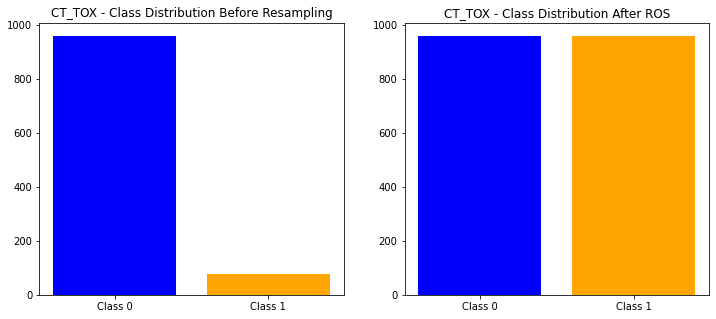

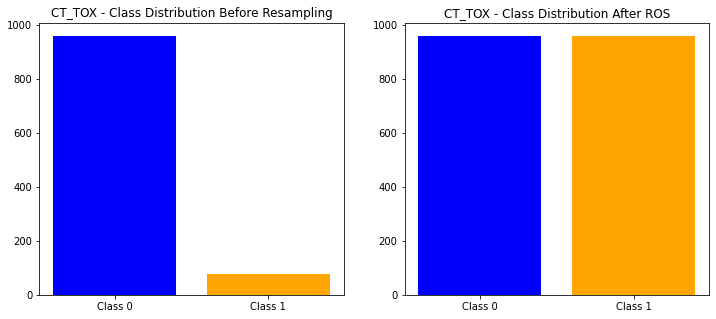

Original y_train size: 1038
Balanced y_train size: 1920
Original X_train size: 1038
Balanced X_train size: 1920
Original class 0 count: 960
Original class 1 count: 78
Balanced class 0 count: 960
Balanced class 1 count: 960
y_test size: 446
x_test size: 446
412
34


In [5]:
def plot_class_distribution(y_train, y_train_balanced, target_name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    train_class_distribution = np.bincount(y_train)
    train_class_distribution_resampled = np.bincount(y_train_balanced)
    ax[0].bar([0, 1], train_class_distribution, color=['blue', 'orange'])
    ax[0].set_title(f'{target_name} - Class Distribution Before Resampling')
    ax[0].set_xticks([0, 1])
    ax[0].set_xticklabels(['Class 0', 'Class 1'])
    ax[1].bar([0, 1], train_class_distribution_resampled, color=['blue', 'orange'])
    ax[1].set_title(f'{target_name} - Class Distribution After ROS')
    ax[1].set_xticks([0, 1])
    ax[1].set_xticklabels(['Class 0', 'Class 1'])
    plt.show()

plot_class_distribution(y_train, y_train_balanced, "CT_TOX")

def plot_class_distribution(X_train, X_train_balanced, target_name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    train_class_distribution = np.bincount(y_train)
    train_class_distribution_resampled = np.bincount(y_train_balanced)
    ax[0].bar([0, 1], train_class_distribution, color=['blue', 'orange'])
    ax[0].set_title(f'{target_name} - Class Distribution Before Resampling')
    ax[0].set_xticks([0, 1])
    ax[0].set_xticklabels(['Class 0', 'Class 1'])
    ax[1].bar([0, 1], train_class_distribution_resampled, color=['blue', 'orange'])
    ax[1].set_title(f'{target_name} - Class Distribution After ROS')
    ax[1].set_xticks([0, 1])
    ax[1].set_xticklabels(['Class 0', 'Class 1'])
    plt.show()

    print(f"Original y_train size: {len(y_train)}")
    print(f"Balanced y_train size: {len(y_train_balanced)}")
    print(f"Original X_train size: {len(X_train)}")
    print(f"Balanced X_train size: {len(X_train_balanced)}")

    original_class_0_count = np.sum(y_train == 0)
    original_class_1_count = np.sum(y_train == 1)
    balanced_class_0_count = np.sum(y_train_balanced == 0)
    balanced_class_1_count = np.sum(y_train_balanced == 1)
    
    print(f"Original class 0 count: {original_class_0_count}")
    print(f"Original class 1 count: {original_class_1_count}")
    print(f"Balanced class 0 count: {balanced_class_0_count}")
    print(f"Balanced class 1 count: {balanced_class_1_count}")

    print(f"y_test size: {len(y_test)}")
    print(f"x_test size: {len(X_test)}")

    print((y_test == 0).sum())
    print((y_test == 1).sum())

plot_class_distribution(X_train, X_train_balanced, "CT_TOX")

In [6]:
def build_and_evaluate_model(input_dim, params):
    num_layers = params['num_layers']
    neurons_per_layer = params['neurons_per_layer']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']
    hidden_activation = params['hidden_activation']
    output_activation = params['output_activation']
    epochs = params['epochs']

    # Define the model
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(neurons_per_layer[i], input_dim=input_dim, activation=hidden_activation))
        else:
            model.add(Dense(neurons_per_layer[i], activation=hidden_activation))
        model.add(BatchNormalization())  # Batch Normalization to stabilize learning
        model.add(Dropout(dropout_rate))  # Dropout layer to prevent overfitting

    model.add(Dense(1, activation=output_activation))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

    # Early stopping and learning rate reduction on plateau
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train the model without W&B callback, manually log metrics
    history = model.fit(
        X_train_balanced, y_train_balanced,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Log metrics manually
    metrics = {
        "validation_loss": loss,
        "validation_accuracy": accuracy
    }
    print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    

    # Return model, accuracy, and history object
    return model, accuracy, history


In [7]:
class ANNOptimizationProblemWithEarlyStopping(Problem):
    def __init__(self, input_dim, max_layers=5, patience=5):
        self.input_dim = input_dim
        self.max_layers = max_layers
        self.patience = patience
        self.best_fitness = -float('inf')
        self.stagnation_count = 0
        super().__init__(
            dimension=1 + max_layers,  # First dimension is number of layers, next are neurons per layer
            lower=[1] + [0] * max_layers,
            upper=[max_layers] + [1] * max_layers,
            type_var=float
        )

    def _evaluate(self, solution):
        num_layers = int(solution[0])
        neurons_per_layer = [
            int(1 + solution[i + 1] * 255)  # Scale neurons in the range [1, 256]
            for i in range(num_layers)
        ]
        params = {
            "num_layers": num_layers,
            "neurons_per_layer": neurons_per_layer,
            "dropout_rate": 0.2,
            "batch_size": 16,
            "hidden_activation": 'tanh',
            "output_activation": 'sigmoid',
            "epochs": 200
        }

        # Build and evaluate the model
        model, accuracy, history = build_and_evaluate_model(self.input_dim, params)

        # Early stopping based on plateau
        if accuracy > self.best_fitness:
            self.best_fitness = accuracy
            self.stagnation_count = 0
        else:
            self.stagnation_count += 1

        if self.stagnation_count >= self.patience:
            self.stagnation_count = self.patience + 1  # Force task to terminate

        return accuracy

In [8]:
class TaskWithEarlyStopping(Task):
    def __init__(self, *args, patience=8, **kwargs):
        super().__init__(*args, **kwargs)
        self.patience = patience
        self.stagnation_count = 0
        self.best_fitness = -float('inf')

    def update(self, algorithm):
        super().update(algorithm)
        current_fitness = algorithm.best_fitness

        if current_fitness > self.best_fitness:
            self.best_fitness = current_fitness
            self.stagnation_count = 0
        else:
            self.stagnation_count += 1

        if self.stagnation_count >= self.patience:
            self.stop()

In [9]:
population_size = 15
max_iters = 20
patience = 8
print(f"Running GWO with Population Size: {population_size} and Max Iterations: {max_iters}")

Running GWO with Population Size: 15 and Max Iterations: 20


In [10]:
problem = ANNOptimizationProblemWithEarlyStopping(input_dim=X_train_balanced.shape[1], max_layers=5, patience=patience)
task = TaskWithEarlyStopping(
    problem=problem,
    max_iters=max_iters,
    enable_logging=True,
    patience=patience
)

In [11]:
gwo = GreyWolfOptimizer(population_size=population_size)
best_solution, fitness_values = gwo.run(task)

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
INFO:niapy.task.Task:evals:1 => 0.9551569223403931


Validation Loss: 0.1689, Validation Accuracy: 0.9552


INFO:niapy.task.Task:evals:2 => 0.9417040348052979


Validation Loss: 0.1656, Validation Accuracy: 0.9417


INFO:niapy.task.Task:evals:3 => 0.926008939743042


Validation Loss: 0.1965, Validation Accuracy: 0.9260
Validation Loss: 0.1838, Validation Accuracy: 0.9529
Validation Loss: 0.1922, Validation Accuracy: 0.9327


INFO:niapy.task.Task:evals:6 => 0.9237667918205261


Validation Loss: 0.1823, Validation Accuracy: 0.9238
Validation Loss: 0.1687, Validation Accuracy: 0.9462
Validation Loss: 0.1801, Validation Accuracy: 0.9439
Validation Loss: 0.1876, Validation Accuracy: 0.9552
Validation Loss: 0.1771, Validation Accuracy: 0.9350
Validation Loss: 0.1656, Validation Accuracy: 0.9619
Validation Loss: 0.2004, Validation Accuracy: 0.9372
Validation Loss: 0.1479, Validation Accuracy: 0.9484
Validation Loss: 0.1879, Validation Accuracy: 0.9462
Validation Loss: 0.1596, Validation Accuracy: 0.9395
Validation Loss: 0.1782, Validation Accuracy: 0.9395
Validation Loss: 0.2087, Validation Accuracy: 0.9507
Validation Loss: 0.2032, Validation Accuracy: 0.9462
Validation Loss: 0.1639, Validation Accuracy: 0.9507
Validation Loss: 0.1674, Validation Accuracy: 0.9574
Validation Loss: 0.1807, Validation Accuracy: 0.9596
Validation Loss: 0.1931, Validation Accuracy: 0.9350
Validation Loss: 0.1631, Validation Accuracy: 0.9439
Validation Loss: 0.1631, Validation Accuracy: 

INFO:niapy.task.Task:evals:71 => 0.9215246438980103


Validation Loss: 0.2367, Validation Accuracy: 0.9215
Validation Loss: 0.1573, Validation Accuracy: 0.9395
Validation Loss: 0.1680, Validation Accuracy: 0.9507
Validation Loss: 0.1641, Validation Accuracy: 0.9596
Validation Loss: 0.1502, Validation Accuracy: 0.9529
Validation Loss: 0.1867, Validation Accuracy: 0.9439


INFO:niapy.task.Task:evals:77 => 0.9125560522079468


Validation Loss: 0.2218, Validation Accuracy: 0.9126
Validation Loss: 0.1832, Validation Accuracy: 0.9596
Validation Loss: 0.1852, Validation Accuracy: 0.9350
Validation Loss: 0.1819, Validation Accuracy: 0.9552
Validation Loss: 0.1989, Validation Accuracy: 0.9439
Validation Loss: 0.1850, Validation Accuracy: 0.9529
Validation Loss: 0.1510, Validation Accuracy: 0.9596
Validation Loss: 0.1697, Validation Accuracy: 0.9574
Validation Loss: 0.1612, Validation Accuracy: 0.9641
Validation Loss: 0.2288, Validation Accuracy: 0.9283
Validation Loss: 0.1776, Validation Accuracy: 0.9439
Validation Loss: 0.1734, Validation Accuracy: 0.9529
Validation Loss: 0.1882, Validation Accuracy: 0.9462
Validation Loss: 0.2401, Validation Accuracy: 0.9215
Validation Loss: 0.2044, Validation Accuracy: 0.9484
Validation Loss: 0.1769, Validation Accuracy: 0.9417
Validation Loss: 0.2290, Validation Accuracy: 0.9148
Validation Loss: 0.1621, Validation Accuracy: 0.9350
Validation Loss: 0.2024, Validation Accuracy: 

INFO:niapy.task.Task:evals:104 => 0.7825112342834473


Validation Loss: 0.5660, Validation Accuracy: 0.7825
Validation Loss: 0.1821, Validation Accuracy: 0.9372
Validation Loss: 0.2646, Validation Accuracy: 0.9058
Validation Loss: 0.1694, Validation Accuracy: 0.9462
Validation Loss: 0.2432, Validation Accuracy: 0.9148
Validation Loss: 0.1577, Validation Accuracy: 0.9574
Validation Loss: 0.2012, Validation Accuracy: 0.9350
Validation Loss: 0.1908, Validation Accuracy: 0.9372
Validation Loss: 0.2856, Validation Accuracy: 0.9081
Validation Loss: 0.4839, Validation Accuracy: 0.9238
Validation Loss: 0.2230, Validation Accuracy: 0.9305
Validation Loss: 0.1781, Validation Accuracy: 0.9439
Validation Loss: 0.2004, Validation Accuracy: 0.9260
Validation Loss: 0.2499, Validation Accuracy: 0.9439
Validation Loss: 0.2387, Validation Accuracy: 0.9193
Validation Loss: 0.2759, Validation Accuracy: 0.9058
Validation Loss: 0.2614, Validation Accuracy: 0.9193
Validation Loss: 0.2131, Validation Accuracy: 0.9350
Validation Loss: 0.1935, Validation Accuracy: 

INFO:niapy.task.Task:evals:172 => 0.7421524524688721


Validation Loss: 0.4777, Validation Accuracy: 0.7422
Validation Loss: 0.2676, Validation Accuracy: 0.9327
Validation Loss: 0.1832, Validation Accuracy: 0.9350
Validation Loss: 0.2675, Validation Accuracy: 0.9283
Validation Loss: 0.2745, Validation Accuracy: 0.8946
Validation Loss: 0.3213, Validation Accuracy: 0.8879
Validation Loss: 0.2519, Validation Accuracy: 0.9215
Validation Loss: 0.1619, Validation Accuracy: 0.9372
Validation Loss: 0.2886, Validation Accuracy: 0.8991
Validation Loss: 0.2707, Validation Accuracy: 0.8744
Validation Loss: 0.2834, Validation Accuracy: 0.8969
Validation Loss: 0.1854, Validation Accuracy: 0.9417
Validation Loss: 0.4472, Validation Accuracy: 0.8677
Validation Loss: 0.4344, Validation Accuracy: 0.8475
Validation Loss: 0.2876, Validation Accuracy: 0.9215
Validation Loss: 0.2296, Validation Accuracy: 0.9327
Validation Loss: 0.2416, Validation Accuracy: 0.9238


INFO:niapy.task.Task:evals:189 => 0.7219731211662292


Validation Loss: 0.6017, Validation Accuracy: 0.7220
Validation Loss: 0.2516, Validation Accuracy: 0.9238
Validation Loss: 0.2232, Validation Accuracy: 0.9170
Validation Loss: 0.5013, Validation Accuracy: 0.9238
Validation Loss: 0.2404, Validation Accuracy: 0.9260
Validation Loss: 0.2096, Validation Accuracy: 0.9417
Validation Loss: 0.2133, Validation Accuracy: 0.9350
Validation Loss: 0.2214, Validation Accuracy: 0.9238
Validation Loss: 0.4124, Validation Accuracy: 0.9238
Validation Loss: 0.2715, Validation Accuracy: 0.9193
Validation Loss: 0.2352, Validation Accuracy: 0.9327
Validation Loss: 0.2781, Validation Accuracy: 0.9013
Validation Loss: 0.2258, Validation Accuracy: 0.9327
Validation Loss: 0.2148, Validation Accuracy: 0.8991
Validation Loss: 0.1993, Validation Accuracy: 0.9417
Validation Loss: 0.1633, Validation Accuracy: 0.9439
Validation Loss: 0.1935, Validation Accuracy: 0.9372
Validation Loss: 0.6156, Validation Accuracy: 0.7668
Validation Loss: 0.1997, Validation Accuracy: 

INFO:niapy.task.Task:evals:213 => 0.5112107396125793


Validation Loss: 0.6903, Validation Accuracy: 0.5112
Validation Loss: 0.3324, Validation Accuracy: 0.8924
Validation Loss: 0.2996, Validation Accuracy: 0.8946
Validation Loss: 0.2071, Validation Accuracy: 0.9327
Validation Loss: 0.4552, Validation Accuracy: 0.8475
Validation Loss: 0.3073, Validation Accuracy: 0.8879
Validation Loss: 0.1881, Validation Accuracy: 0.9417
Validation Loss: 0.2577, Validation Accuracy: 0.9193
Validation Loss: 0.1756, Validation Accuracy: 0.9462
Validation Loss: 0.2892, Validation Accuracy: 0.8857
Validation Loss: 0.2004, Validation Accuracy: 0.9238
Validation Loss: 0.1898, Validation Accuracy: 0.9417
Validation Loss: 0.2405, Validation Accuracy: 0.9305
Validation Loss: 0.2096, Validation Accuracy: 0.9215
Validation Loss: 0.2219, Validation Accuracy: 0.9260
Validation Loss: 0.3967, Validation Accuracy: 0.8722
Validation Loss: 0.2335, Validation Accuracy: 0.9327
Validation Loss: 0.4636, Validation Accuracy: 0.8475
Validation Loss: 0.2500, Validation Accuracy: 

In [12]:
convergence_data = {
    "iterations": task.n_evals,
    "convergence_values": task.fitness_evals  # Convergence value is now the best accuracy
}
joblib.dump(convergence_data, f"convergence_data_pop_{population_size}.joblib")

['convergence_data_pop_15.joblib']

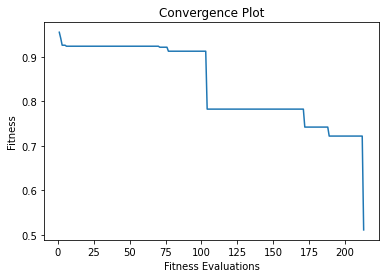

In [13]:
task.plot_convergence(x_axis='evals', title='Convergence Plot')


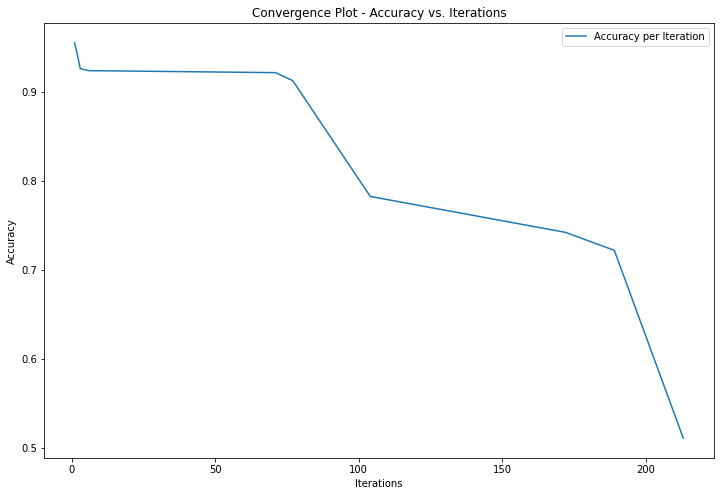

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(convergence_data["iterations"], convergence_data["convergence_values"], label="Accuracy per Iteration")
plt.title("Convergence Plot - Accuracy vs. Iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [72]:
num_layers = int(best_solution[0])
neurons_per_layer = [int(1 + best_solution[i + 1] * 255) for i in range(num_layers)]
optimized_params = {
    "num_layers": num_layers,
    "neurons_per_layer": neurons_per_layer,
    "dropout_rate": 0.1,
    "batch_size": 16,
    "hidden_activation": 'tanh',
    "output_activation": 'sigmoid',
    "epochs": 150
}

# Build and evaluate model with optimized parameters
model, accuracy, history = build_and_evaluate_model(X_train_balanced.shape[1], optimized_params)

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Loss: 0.3409, Validation Accuracy: 0.8901


In [73]:
cm_test = confusion_matrix(y_test, (model.predict(X_test) > 0.5).astype(int))
cm_train = confusion_matrix(y_train_balanced, (model.predict(X_train_balanced) > 0.5).astype(int))

print("\nGWO Results:")
print(f"Optimized Parameters: {optimized_params}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

GWO Results:
Optimized Parameters: {'num_layers': 5, 'neurons_per_layer': [1, 218, 247, 115, 2], 'dropout_rate': 0.1, 'batch_size': 16, 'hidden_activation': 'tanh', 'output_activation': 'sigmoid', 'epochs': 150}


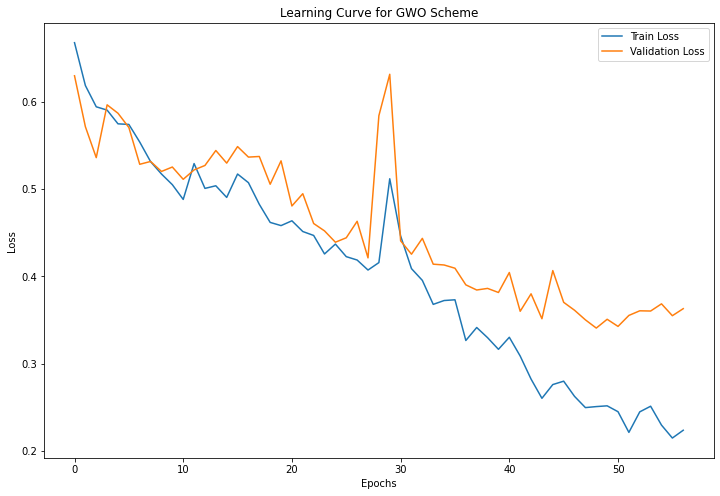

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Results: {'confusion_matrix': array([[376,  36],
       [ 13,  21]], dtype=int64), 'overall_metrics': {'accuracy': 0.8901345291479821, 'precision': 0.3684210526315789, 'recall': 0.6176470588235294, 'f1_score': 0.46153846153846156}}
Train Results: {'confusion_matrix': array([[907,  53],
       [ 13, 947]], dtype=int64), 'overall_metrics': {'accuracy': 0.965625, 'precision': 0.947, 'recall': 0.9864583333333333, 'f1_score': 0.9663265306122449}}


In [74]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Learning Curve for GWO Scheme")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

results_test = {
    "confusion_matrix": cm_test,
    "overall_metrics": {
        "accuracy": accuracy_score(y_test, (model.predict(X_test) > 0.5).astype(int)),
        "precision": precision_score(y_test, (model.predict(X_test) > 0.5).astype(int)),
        "recall": recall_score(y_test, (model.predict(X_test) > 0.5).astype(int)),
        "f1_score": f1_score(y_test, (model.predict(X_test) > 0.5).astype(int))
    }
}

# Train metrics
results_train = {
    "confusion_matrix": cm_train,
    "overall_metrics": {
        "accuracy": accuracy_score(y_train_balanced, (model.predict(X_train_balanced) > 0.5).astype(int)),
        "precision": precision_score(y_train_balanced, (model.predict(X_train_balanced) > 0.5).astype(int)),
        "recall": recall_score(y_train_balanced, (model.predict(X_train_balanced) > 0.5).astype(int)),
        "f1_score": f1_score(y_train_balanced, (model.predict(X_train_balanced) > 0.5).astype(int))
    }
}

# Print results
print("Test Results:", results_test)
print("Train Results:", results_train)


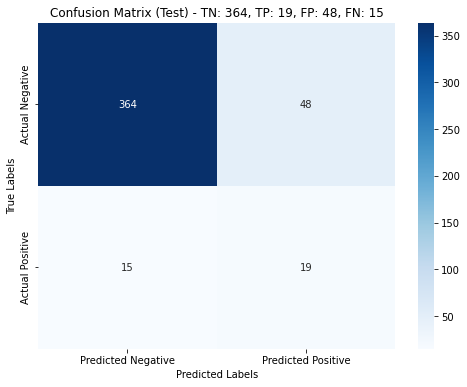

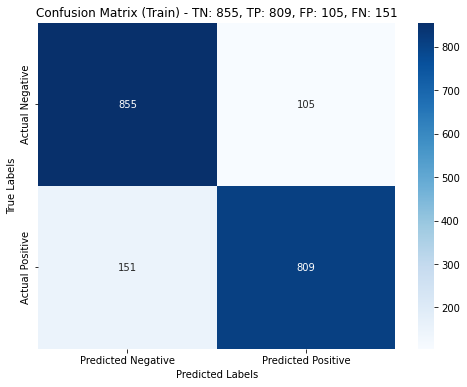

In [68]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title(f"Confusion Matrix (Test) - TN: {cm_test[0][0]}, TP: {cm_test[1][1]}, FP: {cm_test[0][1]}, FN: {cm_test[1][0]}")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title(f"Confusion Matrix (Train) - TN: {cm_train[0][0]}, TP: {cm_train[1][1]}, FP: {cm_train[0][1]}, FN: {cm_train[1][0]}")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

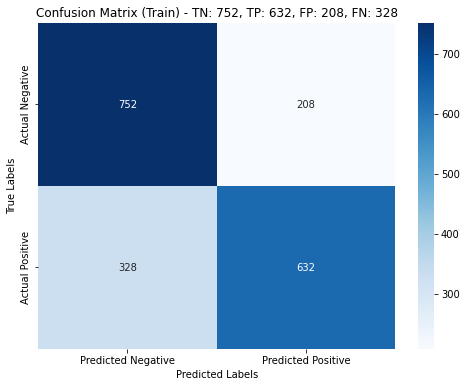

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title(f"Confusion Matrix (Train) - TN: {cm_train[0][0]}, TP: {cm_train[1][1]}, FP: {cm_train[0][1]}, FN: {cm_train[1][0]}")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()